In [16]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [17]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [18]:
import sqlite3
import pandas as pd

db_path = 'real_estate_with_fflag.db'

# 연결
conn = sqlite3.connect(db_path)

df_origin = pd.read_sql("SELECT * FROM house", conn)

conn.close()

In [19]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50840 entries, 0 to 50839
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   house_id            50840 non-null  int64  
 1   title               50840 non-null  object 
 2   price               50840 non-null  object 
 3   address             50840 non-null  object 
 4   floor               50840 non-null  object 
 5   deposit_type        50840 non-null  object 
 6   management_fee      50840 non-null  object 
 7   availabe_from       50840 non-null  object 
 8   house_num           50840 non-null  object 
 9   agent_comm          50840 non-null  object 
 10  agent_info          50840 non-null  object 
 11  rooms_count         50840 non-null  object 
 12  options             50840 non-null  object 
 13  posted_at           50840 non-null  object 
 14  gu                  50840 non-null  object 
 15  dong                50840 non-null  object 
 16  img_

In [20]:
df_origin.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       '보증금', '월세', '전환율', '전세환산금액', '전세가율_이상'],
      dtype='object')

In [21]:
df = df_origin
df = df[df['deposit_type'] != '단기임대']

# 단기임대 데이터 분리
df_dangi = df_origin[df_origin['deposit_type']=='단기임대']

In [22]:
df['deposit_type'].unique()

array(['월세', '전세'], dtype=object)

In [23]:
df['building_type'].unique()

# ['공동주택', '단독주택', '제2종 근린생활시설', '업무시설', '제1종 근린생활시설', '건축물 용도 정보 없음',
#        '미등기건물', '숙박시설', '교육연구시설', '운동시설', '그 밖에 토지의 정착물',
#        '노유자(幼者: 노인 및 어린이)시설', '공장', '창고시설', '의료시설', '자동차 관련 시설']

array(['공동주택', '단독주택', '제2종 근린생활시설', '업무시설', '제1종 근린생활시설', '건축물 용도 정보 없음',
       '미등기건물', '숙박시설', '교육연구시설', '운동시설', '그 밖에 토지의 정착물', '창고시설',
       '노유자(幼者: 노인 및 어린이)시설', '공장', '자동차 관련 시설', '의료시설'], dtype=object)

In [24]:
import pandas as pd
import numpy as np
import re

### 1. 가격/면적/방수/층 전처리 함수 정의
# 단기임대 일단 빼둠
def parse_price_column(df, col='price'):
    def parse_price(text):
        try:
            text = str(text).replace(",", "").replace(" ", "")
            if "월세" in text:
                match = re.search(r'(?:월세|단기임대)([\d억]+)[/\\](\d+)', text)
                if match:
                    deposit_raw = match.group(1)
                    if '억' in deposit_raw:
                        parts = deposit_raw.split('억')
                        deposit = int(parts[0]) * 10000
                        if len(parts) > 1 and parts[1].isdigit():
                            deposit += int(parts[1])
                    else:
                        deposit = int(deposit_raw)
                    deposit *= 10000
                    monthly = int(match.group(2))  * 10000
                    return deposit, monthly
            elif "전세" in text:
                match = re.search(r'전세\s*([\d억]+)', text)
                if match:
                    deposit_raw = match.group(1)
                    if '억' in deposit_raw:
                        parts = deposit_raw.split('억')
                        deposit = int(parts[0]) * 10000
                        if len(parts) > 1 and parts[1].isdigit():
                            deposit += int(parts[1])
                    else:
                        deposit = int(deposit_raw)
                    deposit *= 10000
                    return deposit, 0
        except:
            pass
        return None, None

    df[['보증금', '월세']] = df[col].apply(lambda x: pd.Series(parse_price(x)))
    return df

def parse_area_column(df, col='area_size'):
    def parse_area(area_text):
        try:
            # '74.31㎡/49.92㎡(전용률67%)' 또는 '-㎡/38㎡' 처리
            matches = re.findall(r'([\d.]+)㎡', str(area_text))
            if len(matches) >= 1:
                return float(matches[-1])  # 전용면적만 추출
        except:
            pass
        return None

    df['전용면적'] = df[col].apply(parse_area)
    return df

def parse_rooms_column(df, col='rooms_count'):
    def parse_rooms(text):
        try:
            rooms, baths = re.findall(r'(\d+)', str(text))
            return int(rooms), int(baths)
        except:
            return None, None
    df[['방수', '욕실수']] = df[col].apply(lambda x: pd.Series(parse_rooms(x)))
    return df

def parse_floor_column(df, col='floor'):
    def parse_floor(text):
        try:
            text = str(text).replace(" ", "")
            parts = text.split('/')
            if len(parts) == 2:
                층_raw = parts[0]
                총층_match = re.search(r'(\d+)', parts[1])
                총층 = int(총층_match.group(1)) if 총층_match else None
                해당층_match = re.match(r'(\d+)', 층_raw)
                해당층 = int(해당층_match.group(1)) if 해당층_match else None
                return 해당층, 총층
        except:
            pass
        return None, None
    df[['해당층', '총층']] = df[col].apply(lambda x: pd.Series(parse_floor(x)))
    return df

### 2. 전처리 실행
df = parse_price_column(df)
df = parse_area_column(df)
df = parse_rooms_column(df)
df = parse_floor_column(df)

In [25]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       '보증금', '월세', '전환율', '전세환산금액', '전세가율_이상', '전용면적', '방수', '욕실수', '해당층',
       '총층'],
      dtype='object')

In [26]:
# ['house_id', 'title', 'price', 'deposit', 'monthly_rent','address', 'floor', 'total_floor','deposit_type',
#        'management_fee', 'availabe_from', 'house_num', 'agent_comm',
#        'agent_info', 'rooms_count', 'bath_count','options', 'posted_at', 'gu', 'dong',
#        'img_url', 'area_size', 'direction', 'built_date', 'parking',
#        'building_type', 'house_feature', 'house_explanations', 'apt_name',
#        '전환율', '전세환산금액', '전세가율_이상', '전용면적', '평당가', '평균_평당가', '가격오차율', '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재',
#        '매물키', '중복개수', '중복_이상치', '건물용도불량', '위험점수', '위험매물', 'pseudo', '최종위험점수',
#        '안전등급']



In [27]:
df['보증금']

0        250000000
1        200000000
2        950000000
3        330000000
4        200000000
           ...    
50835    180000000
50836    160000000
50837     10000000
50838     20000000
50839    280000000
Name: 보증금, Length: 50038, dtype: int64

In [28]:
# 가격 이상치 계산 수정
# 전월세 구역별 전환율
gu_rate = {
    # 도심권 (5.3%)
    '종로구': 5.3, '중구': 5.3, '용산구': 5.3,
    # 동북권 (5.1%)
    '성동구': 5.1, '광진구': 5.1, '동대문구': 5.1, '중랑구': 5.1,
    '성북구': 5.1, '강북구': 5.1, '도봉구': 5.1, '노원구': 5.1,
    # 서북권 (5.1%)
    '은평구': 5.1, '서대문구': 5.1, '마포구': 5.1,
    # 서남권 (4.8%)
    '양천구': 4.8, '강서구': 4.8, '구로구': 4.8, '금천구': 4.8,
    '영등포구': 4.8, '동작구': 4.8, '관악구': 4.8,
    # 동남권 (4.3%)
    '서초구': 4.3, '강남구': 4.3, '송파구': 4.3, '강동구': 4.3,
}

df['전환율'] = df['gu'].map(gu_rate)

# 월세 환산 전세금 = 보증금 + (월세 * 12 / 전환율)
# 단기임대 처리 어케할지
mask_wolse = (df['deposit_type'] == '월세')
df.loc[mask_wolse, '전세환산금액'] = df.loc[mask_wolse, '보증금'] + (
    df.loc[mask_wolse, '월세'] * 12 / df.loc[mask_wolse, '전환율']
)

# 전세는 기존 보증금 사용
mask_jeonse = df['deposit_type'] == '전세'
df.loc[mask_jeonse, '전세환산금액'] = df.loc[mask_jeonse, '보증금']

# 평당가 구하기 : 전세가 / (전용면적 / 3.3)
df['평당가'] = df['전세환산금액'] / (df['전용면적'] / 3.3)

# # 전세 평당가
# df.loc[df['deposit_type'] == '전세', '평당가'] = df['보증금'] / df['전용면적']

# # 월세 평당가 -> 보증금 + 월세*100
# df.loc[df['deposit_type'] == '월세', '평당가'] = (df['보증금'] + df['월세'] * 100) / df['전용면적']
# df.loc[df['deposit_type'] == '단기임대', '평당가'] = (df['보증금'] + df['월세'] * 100) / df['전용면적']

df['평균_평당가'] = df.groupby(['gu', 'dong', 'deposit_type'])['평당가'].transform('mean')

# 가격오차율 (0.2 -> 0.4으로 완화 : 단지내(논문) -> 동 단위로 확장해서)
# 낮은 가격, 높은 가격 따로 매길지 (너무 낮은 가격이면 허위 매물일 가능성이 더 높을 것 같음)
df['가격오차율'] = abs(df['평당가'] - df['평균_평당가']) / df['평균_평당가']
df['가격_이상치'] = df['가격오차율'] > 0.4

In [29]:
df[['gu', 'dong', 'deposit_type', '보증금', '월세', '전용면적', '평당가', '평균_평당가', '가격오차율', '전환율']].sample(5)

,gu,dong,deposit_type,보증금,월세,전용면적,평당가,평균_평당가,가격오차율,전환율
41854,용산구,원효로2가,월세,40000000,1150000,20.88,6.733355e+06,6.607998e+06,0.018970,5.3
37801,구로구,오류동,월세,50000000,400000,23.00,7.317391e+06,5.703995e+06,0.282854,4.8
8960,동대문구,답십리동,전세,170000000,0,39.63,1.415594e+07,2.202049e+07,0.357147,5.1
17298,서대문구,북아현동,월세,50000000,900000,26.66,6.451172e+06,4.095664e+06,0.575122,5.1
23323,성북구,삼선동4가,전세,370000000,0,37.07,3.293769e+07,3.317390e+07,0.007120,5.1


In [30]:
### 3. 허위매물 조건 (논문 기반)
판별컬럼 = ['보증금', '월세', '전용면적', '방수', '욕실수', '해당층', 'built_date', 'building_type']

# 1) 가격 이상치 계산 (위 코드에 수정)
# df['평당가'] = df['보증금'] / df['전용면적']
# df['평균_평당가'] = df.groupby(['gu', 'dong', 'd_type'])['평당가'].transform('mean')
# df['가격오차율'] = abs(df['평당가'] - df['평균_평당가']) / df['평균_평당가']
# df['가격_이상치'] = df['가격오차율'] > 0.4

# 2) 정보 미기재
# 정보 없음 이라고 된 컬럼 null로 바꾸기 🚨
df['결측_컬럼수'] = df[판별컬럼].isna().sum(axis=1)
df['층정보_불명확'] = df['floor'].astype(str).str.contains('저|중|고|지하|반지하|옥탑|알수없음')
df['정보_미기재'] = (df['결측_컬럼수'] > 0) | (df['층정보_불명확'])

# 3) 중복 매물 이상치
df['매물키'] = (
    df['gu'] + "_" + df['dong'] + "_" +
    df['deposit_type'].astype(str) + '_' +
    df['price'].astype(str) + '_' +
    df['해당층'].astype(str) + '_' +
    df['총층'].astype(str) + '_' +
    df['방수'].astype(str) + '_' +
    df['욕실수'].astype(str) + '_' +
    df['agent_info'].astype(str)
)
df['중복개수'] = df.groupby('매물키')['매물키'].transform('count')
중복평균 = df['중복개수'].mean()
df['중복_이상치'] = df['중복개수'] > 중복평균

# 4) 건물용도가 주택이 아닌지
불량 = '제2종 근린생활시설|업무시설|제1종 근린생활시설|건축물 용도 정보 없음|' \
         '교육연구시설|운동시설|그 밖에 토지의 정착물|창고시설|' \
         '노유자|공장|자동차 관련 시설|의료시설'

df['건물용도불량'] = df['building_type'].str.contains(불량, na=False)

# 5) 전세가율 판단 (1 : 80%이상(위험))

In [31]:
df[df['가격_이상치'] == True].count()

house_id              29649
title                 29649
price                 29649
address               29649
floor                 29649
deposit_type          29649
management_fee        29649
availabe_from         29649
house_num             29649
agent_comm            29649
agent_info            29649
rooms_count           29649
options               29649
posted_at             29649
gu                    29649
dong                  29649
img_url               29649
area_size             29649
direction             29649
built_date            29649
parking               29649
building_type         29649
house_feature         29649
house_explanations    29649
apt_name              29649
보증금                   29649
월세                    29649
전환율                   29649
전세환산금액                29649
전세가율_이상               29649
전용면적                  29649
방수                    29588
욕실수                   29588
해당층                   20233
총층                    29637
평당가                 

In [32]:
# 방법1 : 셋 다 해당되면 허위 의심

# df['허위의심'] = df['가격_이상치'] & df['정보_미기재'] & df['중복_이상치']

# 방법2 : 각 특성별 가중치를 두기
# 가중치 : 가격_이상치 > 중복_이상치 > 정보_미기재
# 허위의심 True 개수 : 1889 1839

df['위험점수'] = (
    df['가격_이상치'].astype(int) * 2.5 +
    df['중복_이상치'].astype(int) * 1.5 +
    df['정보_미기재'].astype(int) * 2+ 
    df['건물용도불량'].astype(int) * 2 + 
    df['전세가율_이상'] * 2
)

df['위험매물'] = df['위험점수'] > 5

In [33]:
df[df['가격_이상치'] == True]['gu'].value_counts().sort_values(ascending=False)

gu
영등포구    3209
마포구     2112
송파구     1929
강남구     1664
동대문구    1491
성북구     1409
성동구     1397
강서구     1393
은평구     1374
동작구     1298
강동구     1262
서대문구    1211
용산구     1146
광진구     1116
중랑구     1003
구로구      984
서초구      931
중구       772
도봉구      650
관악구      567
강북구      564
양천구      560
금천구      545
종로구      537
노원구      525
Name: count, dtype: int64

In [34]:
score_counts = df['위험점수'].value_counts().sort_index()
print(score_counts)

위험점수
0.0      7610
1.5      1234
2.0      6552
2.5     10802
3.5      2033
4.0      3164
4.5     11938
5.5       719
6.0      2216
6.5      2715
7.5       166
8.0       726
8.5       124
10.0       39
Name: count, dtype: int64


In [35]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       '보증금', '월세', '전환율', '전세환산금액', '전세가율_이상', '전용면적', '방수', '욕실수', '해당층',
       '총층', '평당가', '평균_평당가', '가격오차율', '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재',
       '매물키', '중복개수', '중복_이상치', '건물용도불량', '위험점수', '위험매물'],
      dtype='object')

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# 1. 특성 선택 및 스케일링
features = ['보증금', '월세', '전용면적', '방수', '욕실수', '해당층']
X = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 2. pseudo-label(허위의심:1, 정상:0)
# '허위의심' 라벨 변경 (True -> 1, False -> 0)
def assign_pseudo(label):
    return 1 if label else 0  # 더 이상 -1 사용하지 않음

df['pseudo'] = df['위험매물'].apply(assign_pseudo)

# 3. self-training 학습용 데이터 (이제는 0과 1 둘 다 포함)
X_self = X_scaled.copy()
y_self = df['pseudo']

# 4. 모델 학습
clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf.fit(X_self, y_self)

# 5. 확률 예측 및 최종 의심 플래그
df['최종위험점수'] = np.round(clf.predict_proba(X_scaled)[:, 1], 2)*100
#df['최종허위의심'] = df['최종허위점수'] > 70

In [37]:
df['안전등급'] = pd.cut(df['최종위험점수'],
                      bins=[0, 20, 40, 60, 80, 100],
                      labels=['매우안전','안전','보통','주의','위험'],
                      right=False, include_lowest=True)

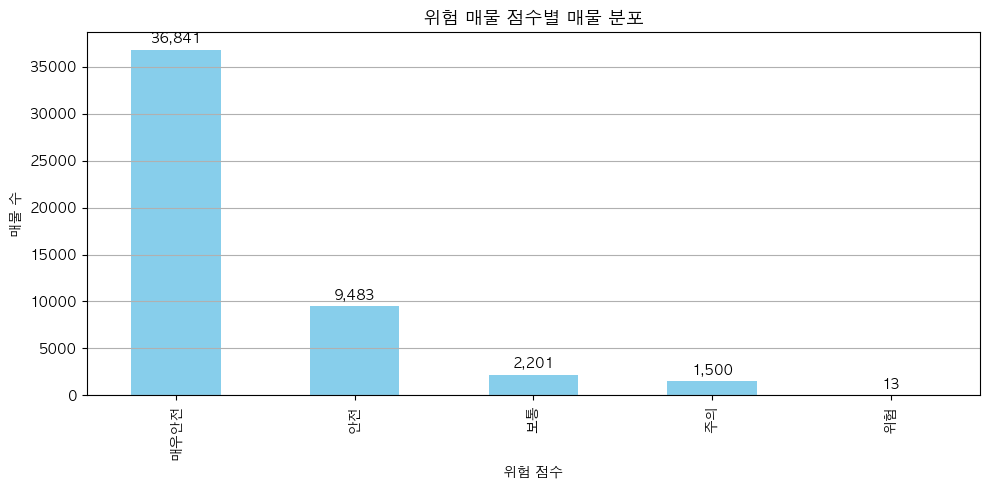

In [38]:
import matplotlib.pyplot as plt

score_counts = df['안전등급'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
score_counts.plot(kind='bar', color='skyblue')

# 막대 위 숫자 표시
for i, count in enumerate(score_counts):
    plt.text(i, count + (score_counts.max() * 0.01), f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.title('위험 매물 점수별 매물 분포', fontsize=13)
plt.xlabel('위험 점수')
plt.ylabel('매물 수')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [39]:
# 위험 등급의 매물들 확인
dangerous_houses = df[df['안전등급'] == '위험']

# 위험 등급의 매물들에 대한 상세 정보 출력
print("위험 등급의 매물 개수:", len(dangerous_houses))
print("\n위험 등급의 매물들 정보:")
print(dangerous_houses[['dong', '보증금', '월세', '평당가', '평균_평당가', '가격오차율']].sample(10))

# 위험 등급의 주요 특징 분석
print("\n평균 가격오차율:", dangerous_houses['가격오차율'].mean())
print("평균 전환율:", dangerous_houses['전환율'].mean())
print("평균 평당가:", dangerous_houses['평당가'].mean())
print("평균 평균_평당가:", dangerous_houses['평균_평당가'].mean())

위험 등급의 매물 개수: 13

위험 등급의 매물들 정보:
        dong        보증금       월세           평당가        평균_평당가     가격오차율
13578   노고산동   10000000  1060000  2.455663e+06  7.569164e+06  0.675570
29932  당산동5가   10000000   900000  2.409118e+06  1.250594e+07  0.807362
41355    서계동   10000000   900000  2.375869e+06  2.976402e+06  0.201765
31244    신길동   10000000   700000  2.305291e+06  4.331522e+06  0.467787
29937  당산동5가   10000000   950000  2.433701e+06  1.250594e+07  0.805396
38331    가산동  185000000    50000  2.681793e+07  8.184979e+06  2.276482
18839    반포동  390000000   200000  2.818989e+07  7.529868e+06  2.743743
8003     염창동  450000000   100000  4.997730e+07  7.738761e+06  5.458049
13423   노고산동   10000000  1000000  2.427916e+06  7.569164e+06  0.679236
29931  당산동5가   10000000   950000  2.433701e+06  1.250594e+07  0.805396

평균 가격오차율: 4.3488638552581715
평균 전환율: 4.83076923076923
평균 평당가: 27645791.489274576
평균 평균_평당가: 7733411.747521635


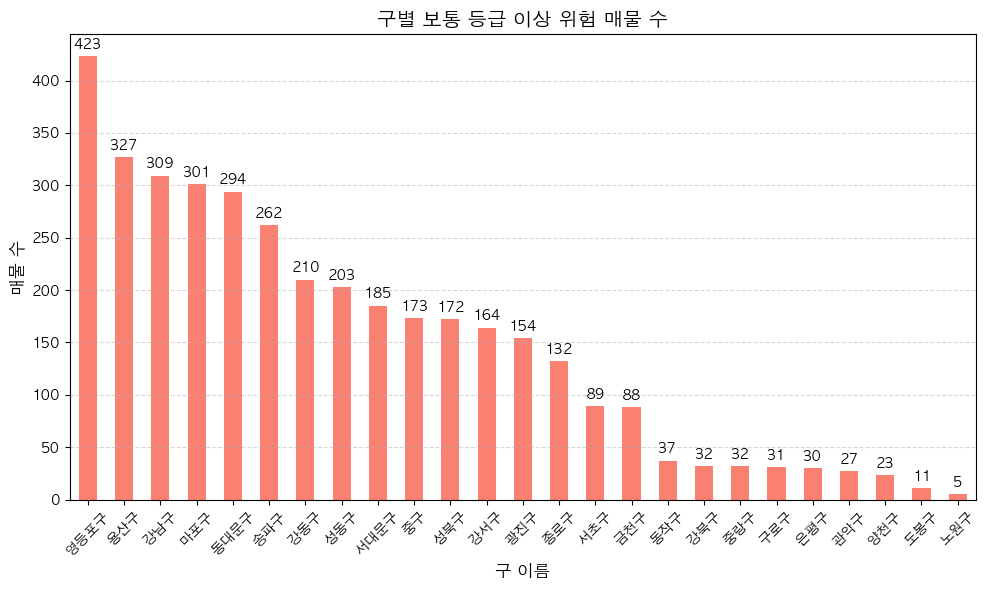

In [40]:
# 1. 40점 이상 매물 필터링
df_high_risk = df[df['최종위험점수'] >= 40]

# 2. 구별 개수 집계
gu_risk_counts = df_high_risk['gu'].value_counts().sort_values(ascending=False)

# 3. 시각화
plt.figure(figsize=(10, 6))
gu_risk_counts.plot(kind='bar', color='salmon')

# 4. 수치 라벨 추가
for i, count in enumerate(gu_risk_counts):
    plt.text(i, count + gu_risk_counts.max()*0.01, f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.title('구별 보통 등급 이상 위험 매물 수', fontsize=14)
plt.xlabel('구 이름', fontsize=12)
plt.ylabel('매물 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
# 구별 전체 매물 수
total_per_gu = df['gu'].value_counts()

# 구별 위험 매물 수
risk_per_gu = df[df['최종위험점수'] >= 40]['gu'].value_counts()

# 비율 계산
risk_ratio = (risk_per_gu / total_per_gu * 100).sort_values(ascending=False)

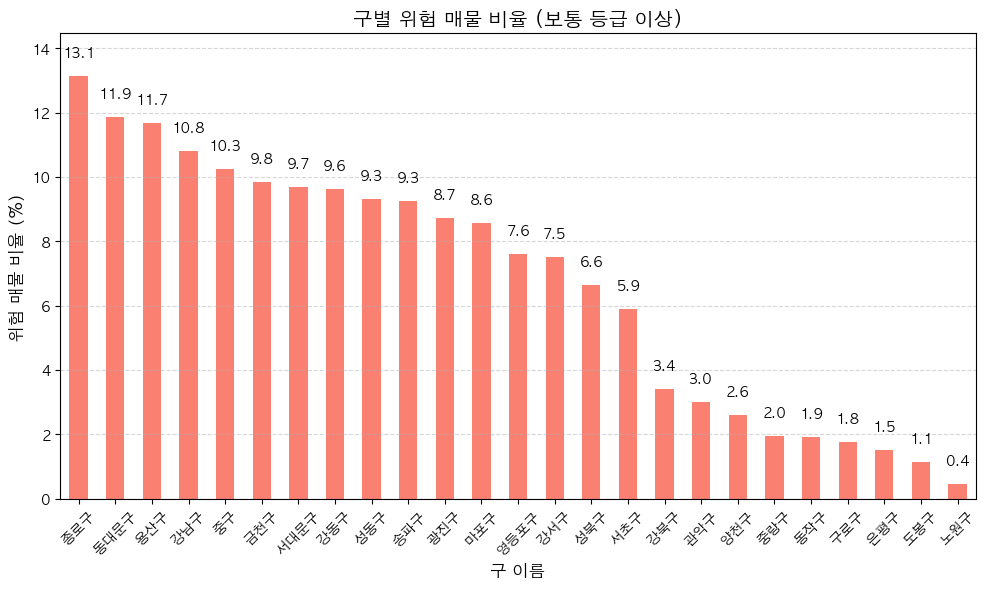

In [42]:
plt.figure(figsize=(10, 6))
risk_ratio.plot(kind='bar', color='salmon')

# 비율 수치 표시
for i, ratio in enumerate(risk_ratio):
    plt.text(i, ratio + 0.5, f'{ratio:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('구별 위험 매물 비율 (보통 등급 이상)', fontsize=14)
plt.xlabel('구 이름', fontsize=12)
plt.ylabel('위험 매물 비율 (%)', fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, risk_ratio.max() * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [43]:
df_origin.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       '보증금', '월세', '전환율', '전세환산금액', '전세가율_이상'],
      dtype='object')

In [51]:
df.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       '보증금', '월세', '전환율', '전세환산금액', '전세가율_이상', '전용면적', '방수', '욕실수', '해당층',
       '총층', '평당가', '평균_평당가', '가격오차율', '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재',
       '매물키', '중복개수', '중복_이상치', '건물용도불량', '위험점수', '위험매물', 'pseudo', '최종위험점수',
       '안전등급'],
      dtype='object')

In [52]:
df_final = df.drop(['보증금', '월세', '전환율', '전세환산금액', '전세가율_이상', '전용면적', '방수', '욕실수', '해당층',
       '총층', '평당가', '평균_평당가', '가격오차율', '가격_이상치', '결측_컬럼수', '층정보_불명확', '정보_미기재',
       '매물키', '중복개수', '중복_이상치', '건물용도불량', '위험점수', '위험매물', 'pseudo', '최종위험점수'], axis=1)

In [ ]:
df_final['safety_grade'] = df_final['안전등급']

In [55]:
df_final = df_final.drop(['안전등급'], axis=1)

In [56]:
df_final.columns

Index(['house_id', 'title', 'price', 'address', 'floor', 'deposit_type',
       'management_fee', 'availabe_from', 'house_num', 'agent_comm',
       'agent_info', 'rooms_count', 'options', 'posted_at', 'gu', 'dong',
       'img_url', 'area_size', 'direction', 'built_date', 'parking',
       'building_type', 'house_feature', 'house_explanations', 'apt_name',
       'safety_grade'],
      dtype='object')

In [58]:
# 단기임대 데이터 병합해서 다시 삽입

df_all = pd.concat([df_final, df_dangi], ignore_index=True)

In [62]:
df_all = df_all.drop(['보증금', '월세', '전환율', '전세환산금액', '전세가율_이상'], axis=1)

In [63]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50840 entries, 0 to 50839
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   house_id            50840 non-null  int64   
 1   title               50840 non-null  object  
 2   price               50840 non-null  object  
 3   address             50840 non-null  object  
 4   floor               50840 non-null  object  
 5   deposit_type        50840 non-null  object  
 6   management_fee      50840 non-null  object  
 7   availabe_from       50840 non-null  object  
 8   house_num           50840 non-null  object  
 9   agent_comm          50840 non-null  object  
 10  agent_info          50840 non-null  object  
 11  rooms_count         50840 non-null  object  
 12  options             50840 non-null  object  
 13  posted_at           50840 non-null  object  
 14  gu                  50840 non-null  object  
 15  dong                50840 non-null  

In [66]:
import sqlite3

# 데이터베이스 연결
conn = sqlite3.connect('real_estate_with_grade.db')

# 데이터프레임을 SQLite 테이블로 저장
df_all.to_sql('house', conn, if_exists='replace', index=False)

# 연결 종료
conn.close()

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # 특성 및 라벨 준비
# features = ['보증금', '월세', '전용면적', '방수', '욕실수', '해당층']
# X = df[features].fillna(0)
# y = df['허위의심'].astype(int)

# # 스케일링
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 비교할 모델 정의
# models = {
#     'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
#     'LightGBM': LGBMClassifier(n_estimators=100, random_state=42),
#     'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
#     'LogisticRegression': LogisticRegression(max_iter=1000)
# }

# # 교차 검증 결과 저장
# results = {}
# for name, model in models.items():
#     scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')
#     results[name] = {
#         'mean_auc': round(scores.mean(), 4),
#         'std_auc': round(scores.std(), 4)
#     }

# # 시각화
# results_df = pd.DataFrame(results).T.sort_values('mean_auc', ascending=False)
# plt.figure(figsize=(8, 4))
# plt.bar(results_df.index, results_df['mean_auc'], yerr=results_df['std_auc'], capsize=5, color='salmon')
# plt.ylabel("ROC AUC (5-fold CV)")
# plt.title("모델별 허위매물 점수 예측 성능 비교")
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()

In [ ]:
# # 시각화
# counts = df['최종허위의심'].value_counts().sort_index()  # False(정상매물) 먼저 나오도록

# plt.figure(figsize=(6, 4))
# counts.plot(kind='bar', color=['skyblue', 'salmon'])

# for i, count in enumerate(counts):
#     plt.text(i, count + (counts.max() * 0.01), f'{count:,}', ha='center', va='bottom', fontsize=11)

# plt.xticks([0, 1], ['정상 매물', '허위 의심 매물'], rotation=0)
# plt.ylabel('매물 수')
# plt.grid(axis='y')
# plt.tight_layout()
# plt.show()

In [ ]:
# # 구 + 동별 허위의심 매물 개수 (True 개수만)
# gu_fraud_counts = df.groupby(['gu'])['최종허위의심'].sum().astype(int)

# print(gu_fraud_counts)

In [ ]:
# df[['title', 'price', 'gu', 'dong', 'd_type','보증금', '월세', '평당가', '전용면적','평균_평당가','가격_이상치', '중복_이상치', '정보_미기재']][df['최종허위의심']==True]